__File: snmd_lamb_dependence.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 18, 2021__

Testing $\lambda$ dependence of proton momentum distribution.

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
import time
# Scripts made by A.T.
from Figures import figures_functions as ff
from densities import load_density
from Potentials.vsrg_macos import vnn
from snmd import single_nucleon_momentum_distributions

__Set-up__

In [2]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)
setup_rc_params(presentation=True)

In [4]:
# Save figures in the following directory (you can change this in the Dropbox)
figure_directory = 'Figures/SRC_physics'

kvnn = 6
channels = ('1S0', '3S1')
lambda_array = np.append( np.arange(8.0, 1.0, -0.5), 1.35 )
m = len(lambda_array)
kmax, kmid, ntot = 15.0, 3.0, 120

# q values
q_points = np.array([1.5, 2.0, 3.0, 4.0, 5.0])
n = len(q_points)

# Full momentum array
q_array, _ = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)

# Nucleus
# nucleus = ('C12', 6, 6)
nucleus = ('Pb208', 82, 126)

nucleus_name = nucleus[0]
Z = nucleus[1]
N = nucleus[2]

# Load densities
r_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N)
r_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N)

__SRG-evolve AV18__

In [5]:
# Already did 8, 7.5, ..., 1.5, 1.35
# Add more?

# from run_srg import run_srg

# for channel in channels:
#     d = run_srg(kvnn, channel, kmax, kmid, ntot, 'Wegner', lambda_array, save=True)

__Calculate proton $n_{\lambda}^A(q_i)$ for fixed $q_i$__

In [6]:
# Calculate n_{\lambda_i}^A(q_j) for ith \lambda and jth q

# Initialize array for data
proton_snmd_array = np.zeros( (m, n) )

# Do full momentum array?
full = True
# full = False
if full:
    n_p_array = np.zeros( (m, ntot) )

# Loop over \lambda values
for i, lamb in enumerate(lambda_array):

    # Initialize class
    snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=False)

    # Evaluate momentum distribution at q_i
    proton_snmd_array[i, :] = snmd.n_lambda(q_points, r_array, rho_p_array, rho_n_array)[:, 0]
    
    if full:
        n_p_array[i, :] = snmd.n_lambda(q_array, r_array, rho_p_array, rho_n_array)[:, 0]
    
    print('Done with \lambda = %.2f fm^-1.' % lamb)
    
# TESTING
if not full:
    n_p_array = proton_snmd_array
    q_array = q_points

Done with \lambda = 8.00 fm^-1.
Done with \lambda = 7.50 fm^-1.
Done with \lambda = 7.00 fm^-1.
Done with \lambda = 6.50 fm^-1.
Done with \lambda = 6.00 fm^-1.
Done with \lambda = 5.50 fm^-1.
Done with \lambda = 5.00 fm^-1.
Done with \lambda = 4.50 fm^-1.
Done with \lambda = 4.00 fm^-1.
Done with \lambda = 3.50 fm^-1.
Done with \lambda = 3.00 fm^-1.
Done with \lambda = 2.50 fm^-1.
Done with \lambda = 2.00 fm^-1.
Done with \lambda = 1.50 fm^-1.
Done with \lambda = 1.35 fm^-1.


__Plot proton $n_{\lambda}^A(q_i)$ for fixed $q_i$ with respect to $\lambda$__

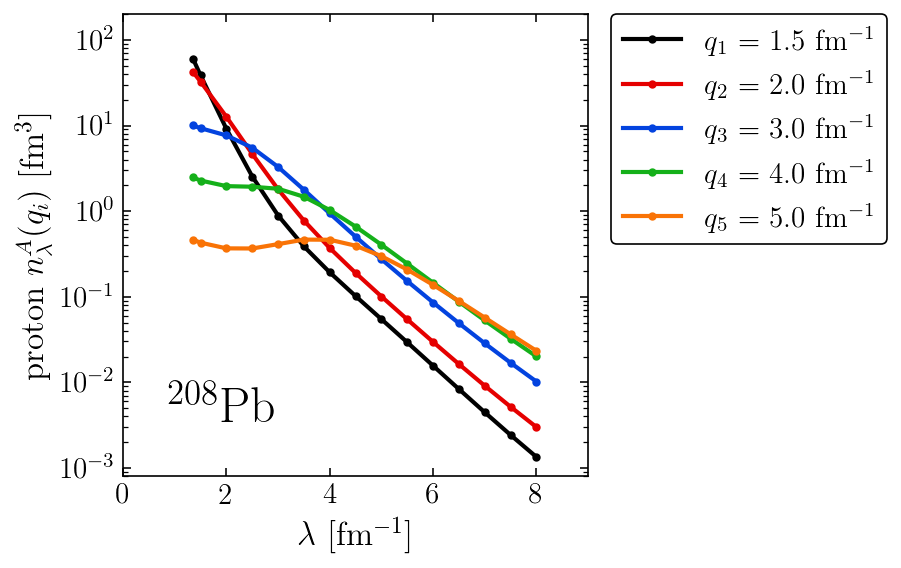

In [7]:
# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'proton ' + r'$n_{\lambda}^A(q_i)$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim = (0.0, 9.0)
if nucleus_name == 'C12':
    ylim = (3e-5, 1e1)
elif nucleus_name == 'Pb208':
    ylim = (8e-4, 2e2)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Set y-axis to log scale
ax.set_yscale('log')

# Loop over q_i points
for i, q_i in enumerate(q_points):
    
    # Legend label
    curve_label = r'$q_{%d}$' % (i+1) + ' = %s fm' % ff.convert_number_to_string(q_i) + r'$^{-1}$'
    curve_color = ff.xkcd_colors(i)
    
    # Add curve to figure
    ax.plot(lambda_array, proton_snmd_array[:, i], color=curve_color, marker='.', label=curve_label,
            linewidth=curve_width)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 14
legend_location = 'upper left'
ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# Add nucleus label as anchored text
nuc_label = ff.nuclei_label_conversion(nucleus_name)
nuc_label_location = 'lower left'
nuc_label_size = 24
anchored_text = AnchoredText(nuc_label, loc=nuc_label_location, prop=dict(size=nuc_label_size), frameon=False)
ax.add_artist(anchored_text)

# Set file_name 
file_name = 'snmd_lamb_dep_kvnn_%d_%s.png' % (kvnn, nucleus_name)

# Save figure
f.savefig(figure_directory + '/' + file_name)

__Plot proton $n_{\lambda_i}^A(q)$ for fixed $\lambda_i$ with respect to $q$__

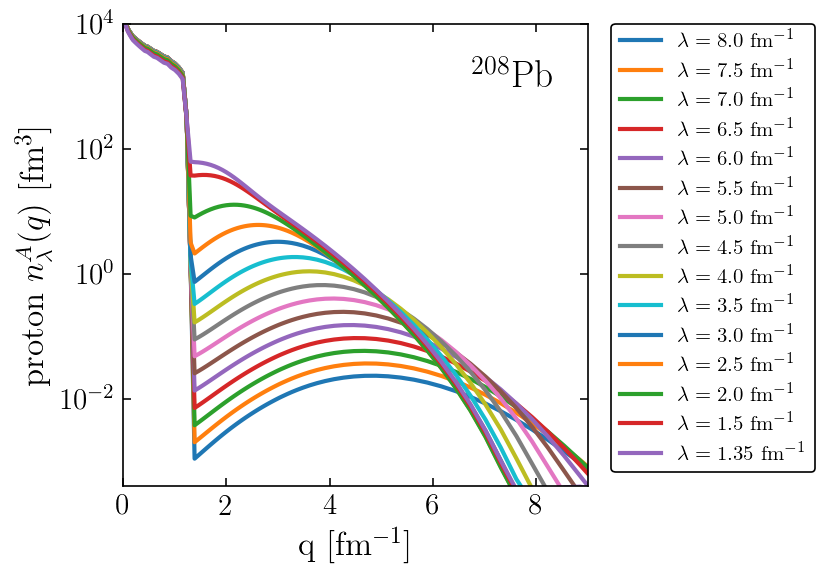

In [16]:
# Plot single-nucleon momentum distributions comparing to AV18 data varying \lambda values
# Copied from src_physics_fig.ipynb

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'proton ' + r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

xlim = (0.0, 9.0)
if nucleus_name == 'C12':
    ylim = (3e-5, 1e1)
elif nucleus_name == 'Pb208':
    ylim = (4e-4, 1e4)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)
    
# Set y-axis to log scale
ax.set_yscale('log')

# Plot each for each \lambda value in lambda_array
for i, lamb in enumerate(lambda_array):

    # Legend label
    curve_label = ff.lambda_label_conversion(lamb) # Labels \lambda
     
    # Add curve to figure
    ax.plot(q_array, n_p_array[i, :], label=curve_label, linewidth=curve_width)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 10
legend_location = 'upper left'
ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
           
# Add nucleus label
nucleus_label = ff.nuclei_label_conversion(nucleus[0])
nucleus_label_location = 'upper right'
nucleus_label_size = 18
anchored_text = AnchoredText(nuc_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
                             frameon=False)
ax.add_artist(anchored_text)
           
# Set file name
file_name = 'snmd_with_AV18_vary_lambda_%s' % nuc_label
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lambdas' % 6
# Add each \lambda to file name
for ilamb in lambda_array:
    file_name += '_%s' % ff.convert_number_to_string(ilamb)
file_name += '_kmax_%.1f' % kmax
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)